In [1]:
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataloader import gen_train_test
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from model import ZScore
import numpy as np



/home/fcg/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'gamma': 0.00001,  # 损失函数降低的最小阈值
    'max_depth': 10,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

In [3]:

train_all_x, train_all_y, train_all_fault, test_all_x, test_all_y, test_all_fault = gen_train_test()
print(type(train_all_x))
print(train_all_x.shape)
print(test_all_x.shape)
print(train_all_y.max(),train_all_y.min())
print(train_all_x.max(),train_all_x.min())


<class 'numpy.ndarray'>
(2818, 46)
(795, 46)
21175.0 0.0
13648.0 0.0


In [4]:
x_means, x_std, _ = ZScore(np.vstack((train_all_x, test_all_x)))
train_all_x = (train_all_x-x_means)/x_std
test_all_x = (test_all_x-x_means)/x_std

y_means, y_std, _ = ZScore(np.vstack((train_all_y, test_all_y)))
train_all_y = (train_all_y-y_means)/y_std
test_all_y = (test_all_y-y_means)/y_std

print(train_all_x.max(), test_all_x.max(), train_all_y.max(), test_all_y.max())


[6.65628564e+02 2.76022696e+01 6.66581788e+01 2.83764185e+01
 2.26891503e+02 3.19704678e+02 6.70000000e+02 4.17943537e+01
 2.75870468e+01 2.76778301e-04 6.65934127e+01 1.65555494e+02
 6.66769997e+01 6.37954608e+01 5.87932466e+00 1.23692776e+02
 6.66847495e+01 6.37835594e+00 2.67184611e+02 6.66611126e+02
 6.66446167e+01 2.76778301e-04 6.37705508e+01 5.98007196e+00
 6.37558815e+00 5.99141987e+00 2.75804041e+01 2.79677277e+02
 5.75087185e+01 2.25128979e+02 2.84157210e+01 3.49986715e+02
 6.35842790e+01 2.76778301e-04 2.79058954e+01 0.00000000e+00
 5.88153889e+00 2.76161085e+01 6.68923609e+02 6.37503460e+01
 6.66114033e+01 2.76778301e-04 6.38378079e+01 2.76778301e-04
 2.76778301e-04 2.75643510e+01] [6.76641020e+02 2.85017102e+01 6.69135312e+01 2.96612486e+01
 1.28667447e+03 1.79222127e+03 6.73752071e+02 4.23774775e+01
 2.85529690e+01 1.66343528e-02 6.68877379e+01 1.03159403e+03
 6.70217196e+01 6.45398836e+01 6.32423553e+00 8.47843228e+02
 6.69954411e+01 6.78310097e+00 1.55237324e+03 6.82739

/home/fcg/lzd/blackBoxModel/model.py:50: RuntimeWarning: invalid value encountered in true_divide
  return means,std,(x-means)/std
/home/fcg/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fcg/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


[19:42:55] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


(795,)


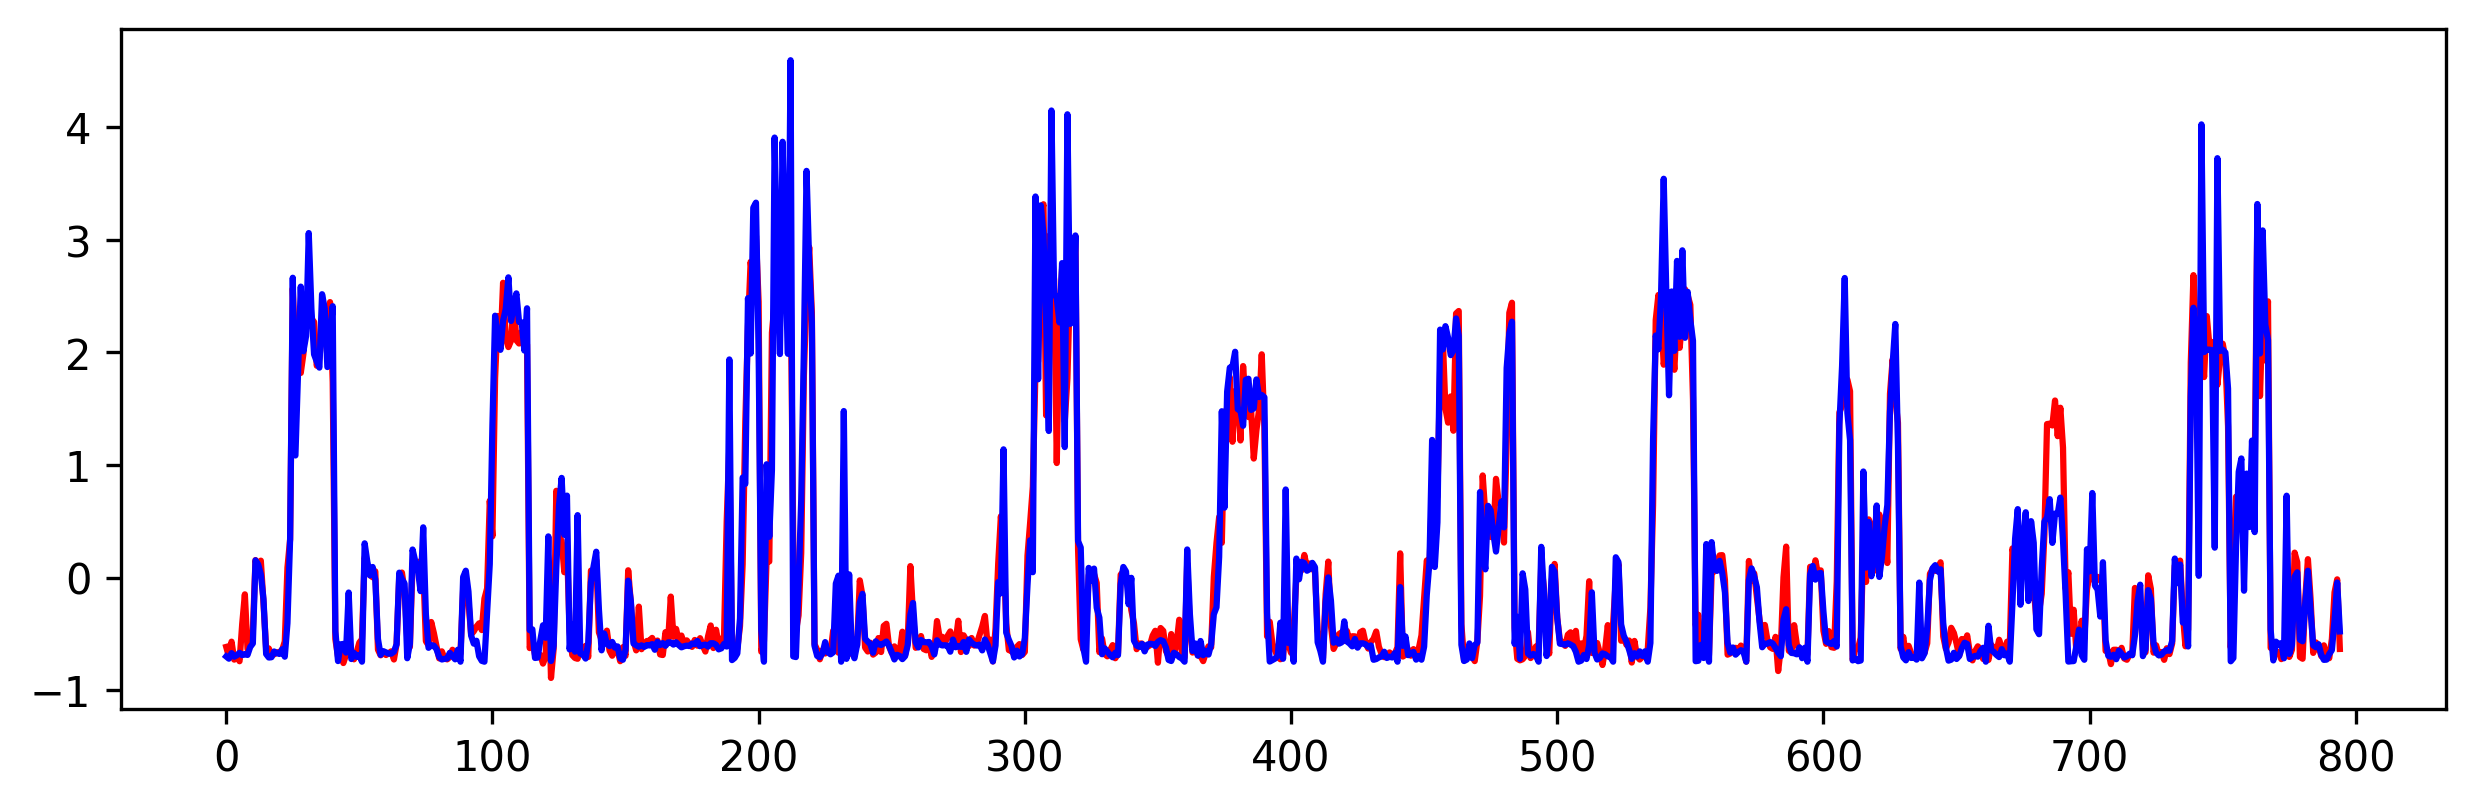

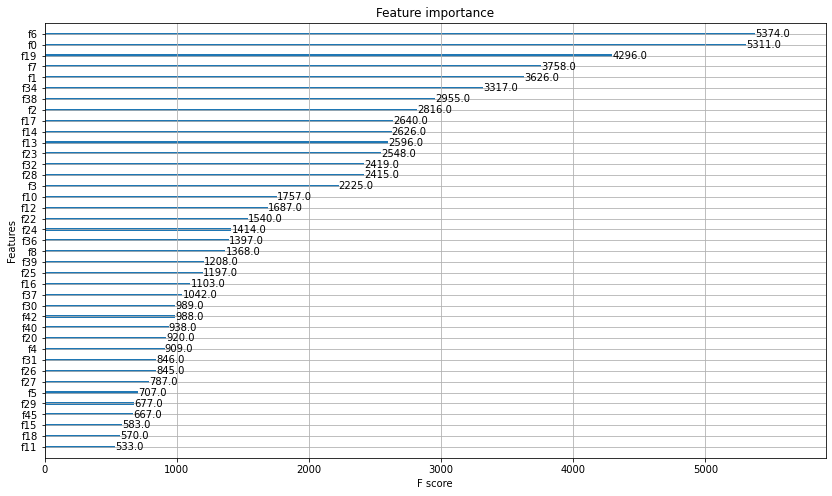

In [5]:
# 把训练特征数据，训练标签数据，进行矩阵的转化
dtrain = xgb.DMatrix(train_all_x, train_all_y.squeeze())

# 弱学习器的个数，及迭代的次数
num_rounds = 3000
plst = list(params.items())

# 训练模型
# 指定参数，训练数据，弱学习器的个数
model = xgb.train(plst, dtrain, num_rounds)

# 对测试集进行预测
dtest = xgb.DMatrix(test_all_x)
ans = model.predict(dtest)
print(ans.shape)
plt.figure(figsize=(10,3),dpi=300)
plt.plot(list(range(ans.shape[0])),ans,color="red",label= "predict")
plt.plot(list(range(ans.shape[0])),test_all_y.squeeze(),color="blue",label="label")
# 显示重要特征
plt.rcParams["figure.figsize"] = (14, 8)
plot_importance(model)
plt.show()


In [6]:
import pandas as pd
import time
from datetime import datetime


def get_sqls():
    lines = open("sql_dict.txt","r").readlines()
    return lines

def get_imp(idx,feat_imp):
    if "f"+str(idx) in feat_imp:
        return feat_imp["f"+str(idx)]
    else:
        return 0

sqls = get_sqls()

importance_eval_list = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for i, importance_type in enumerate(importance_eval_list):
    feat_importance = model.get_score(importance_type=importance_type)
    data = sorted(list(enumerate(sqls)),key=lambda item:get_imp(item[0],feat_importance))
    _data = [item[1] for item in data]
    print(importance_type+":")
    for sql in _data:
        print(sql)
        
    print("\n\n\n")

     



weight:
insert into aa select generate_series(1,100), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), now();

insert into aa select generate_series(1,100), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(random()*999)::text,33), repeat(round(rando